In [9]:
# built-in python modules
import os, sys
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# import pvsyst module
cwd = os.getcwd()
print('current workign directory: {}'.format(cwd))
sys.path.append(os.path.dirname(cwd))  # append to path to be able to import module
import pvsyst
print('pvsyst module path: {}'.format(pvsyst.__file__))

# finally, we import the pvlib library
import pvlib


current workign directory: /Users/frivollier/pvsystlib/pvsyst_tools/docs
pvsyst module path: /Users/frivollier/pvsystlib/pvsyst_tools/pvsyst/__init__.py


Location: 
  name: Guelph
  latitude: 38.0
  longitude: -85.0
  altitude: 197.5994110107422
  tz: -5.0


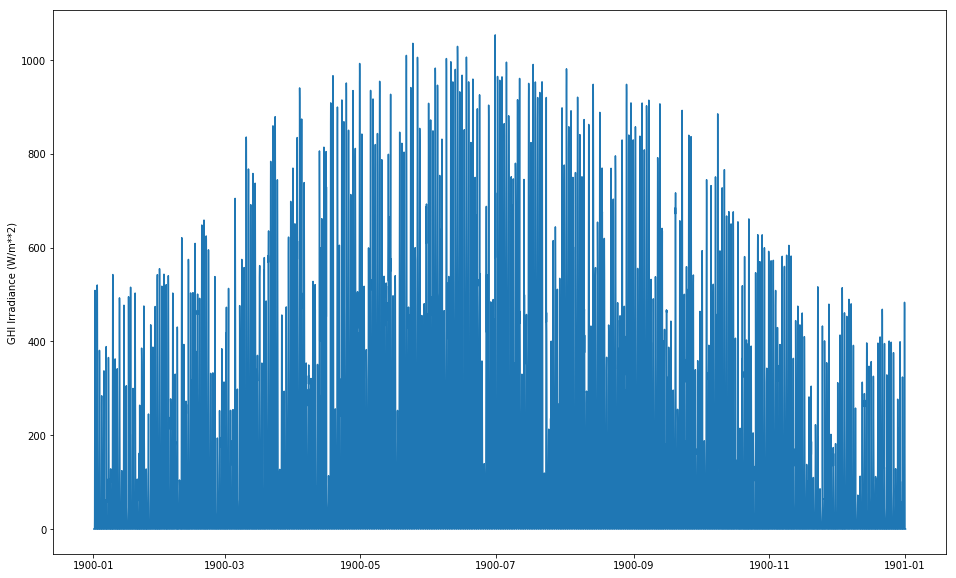

In [10]:
# load TMY data
# absolute path to a data file
datapath = os.path.join(cwd, 'data', 'Guelph_38_-85_tmy3.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.iotools.read_tmy3(datapath)
plt.figure(figsize=(16, 10))

plt.ylabel('GHI Irradiance (W/m**2)')

# create pvlib Location object based on meta data of TMY file
loc = pvlib.location.Location.from_tmy(meta)
print(loc)
plt.plot(tmy_data['GHI'])
plt.show()

In [11]:
# system parameters
surface_tilt = 20
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

iam loss -1.4249941603528105 %
annual ghi = 1482.396918576551 kWh/m2/yr
annual poa = 1638.4406588916495 kWh/m2/yr
transposition gain = 10.526447968128338 %


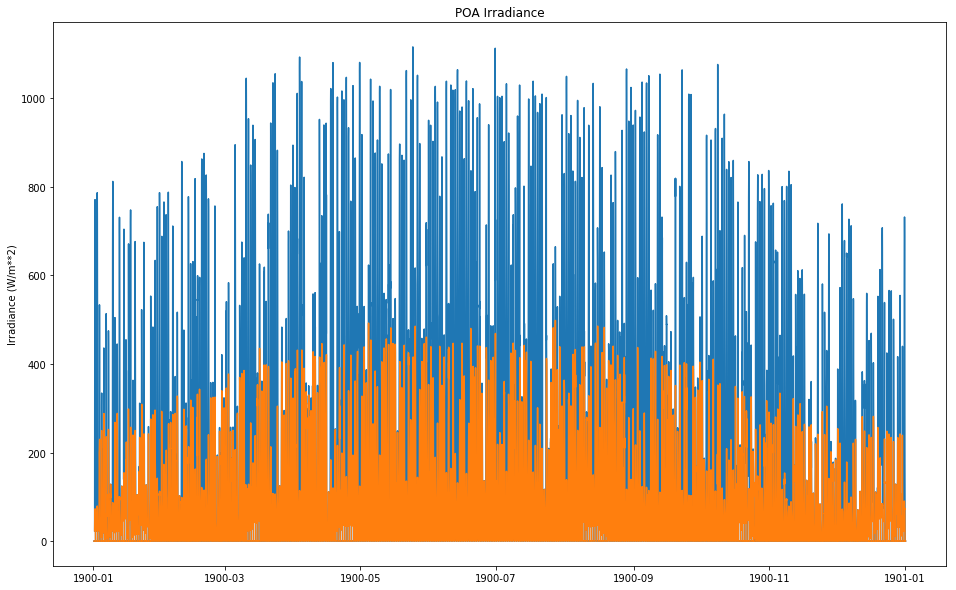

In [22]:
# calculate poa irradinace 

solpos = pvlib.solarposition.get_solarposition(tmy_data.index, loc.latitude, loc.longitude)

dni_extra = pd.Series(pvlib.irradiance.get_extra_radiation(tmy_data.index),
                      index=tmy_data.index)

airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
poa_sky_diffuse = pvlib.irradiance.perez(surface_tilt, 
                                        surface_azimuth,
                                        dhi=tmy_data['DHI'], 
                                        dni=tmy_data['DNI'], 
                                        dni_extra=dni_extra,
                                        solar_zenith=solpos['apparent_zenith'], 
                                        solar_azimuth=solpos['azimuth'],
                                        airmass=airmass)


poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt, tmy_data['GHI'], albedo=albedo)

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])
poa_irrad = pvlib.irradiance.poa_components(aoi, tmy_data['DNI'], poa_sky_diffuse, poa_ground_diffuse)

iam = pvlib.pvsystem.ashraeiam(aoi, b=0.05)  # TODO work on applying ['IAM'] paramter 

poa_irrad['effective'] = (poa_irrad['poa_direct']*iam) + poa_irrad['poa_diffuse']

iam_loss  = (poa_irrad['effective'].sum()/(poa_irrad['poa_global'].sum()))-1
print('iam loss {} %'.format(iam_loss*100))


yearly_poa = poa_irrad['poa_global'].sum() / 1000.0  # kWh
yearly_ghi = tmy_data['GHI'].sum() / 1000.0  # kWh
monthly = poa_irrad['poa_global'].resample('M').sum() / 1000.0
print('annual ghi = {} kWh/m2/yr'.format(yearly_ghi))
print('annual poa = {} kWh/m2/yr'.format(yearly_poa))
print('transposition gain = {} %'.format(((yearly_poa/yearly_ghi)-1)*100))


plt.figure(figsize=(16, 10))
plt.ylabel('Irradiance (W/m**2)')
plt.title('POA Irradiance')

plt.plot(poa_irrad[['effective','poa_diffuse']])

plt.show()



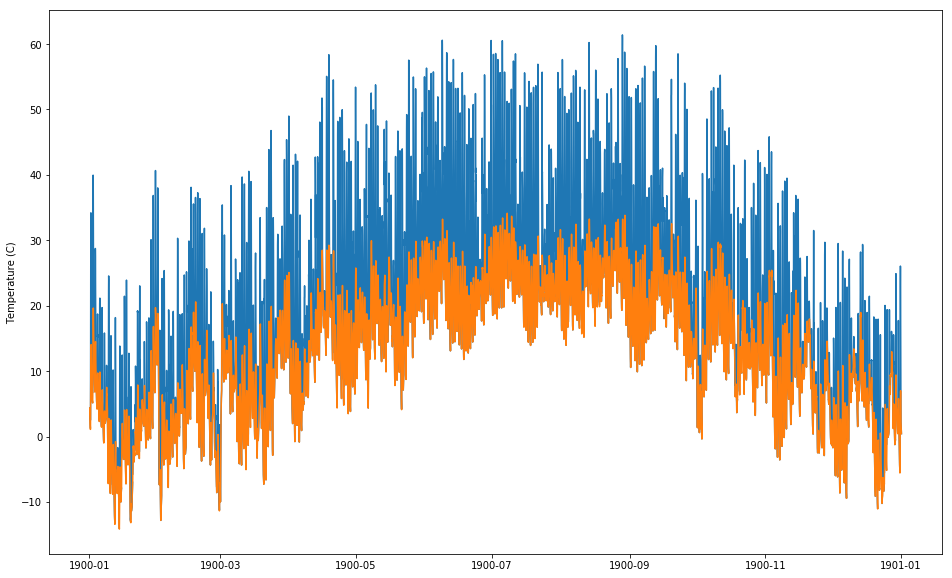

In [13]:
# calculate cell temperaure
pvtemps = pvlib.pvsystem.pvsyst_celltemp(poa_irrad['poa_global'], tmy_data['DryBulb'])

plt.figure(figsize=(16, 10))
plt.ylabel('Temperature (C)')
plt.plot(pvtemps)
plt.plot(tmy_data['DryBulb'])
plt.show()


In [14]:
# set PAN file path
pan_dir = r'data'  # directory of PAN files}
pan = os.path.join(pan_dir,'CS3U-365P_MIX_CSIHE_EXT_V6_70_1500V_2018Q2.PAN')  # example PAN file
# parse .PAN file into dict 
module_parameters = pvsyst.pan_to_module_param(pan)  # return two dicts

print(module_parameters)

{'manufacturer': 'Canadian Solar Inc.', 'module_name': 'CS3U-365P 1500V HE', 'Technol': 'mtSiPoly', 'CellsInS': 72, 'CellsInP': 2, 'GRef': 1000.0, 'TRef': 25.0, 'Pmpp': 365.0, 'Isc': 9.75, 'Voc': 47.2, 'Impp': 9.18, 'Vmpp': 39.8, 'mIsc_percent': 0.05005128205128205, 'mVoc_percent': -0.2902542372881356, 'mIsc': 0.00488, 'mVoc': -0.137, 'mPmpp': -0.37, 'Rshunt': 600.0, 'Rsh 0': 2500.0, 'Rshexp': 5.5, 'Rserie': 0.239, 'Gamma': 0.952, 'muGamma': -0.0004, 'IAM': array([[10.  , 20.  , 30.  , 40.  , 50.  , 60.  , 70.  , 80.  , 90.  ],
       [ 1.  ,  1.  ,  1.  ,  0.99,  0.99,  0.97,  0.92,  0.76,  0.  ]]), 'gamma_ref': 0.952, 'mu_gamma': -0.0004, 'I_L_ref': 9.75, 'I_o_ref': 2.2024892658346175e-11, 'EgRef': 1.121, 'R_sh_ref': 600.0, 'R_sh_0': 2500.0, 'R_s': 0.239, 'R_sh_exp': 5.5, 'cells_in_series': 72, 'alpha_sc': 0.00488}


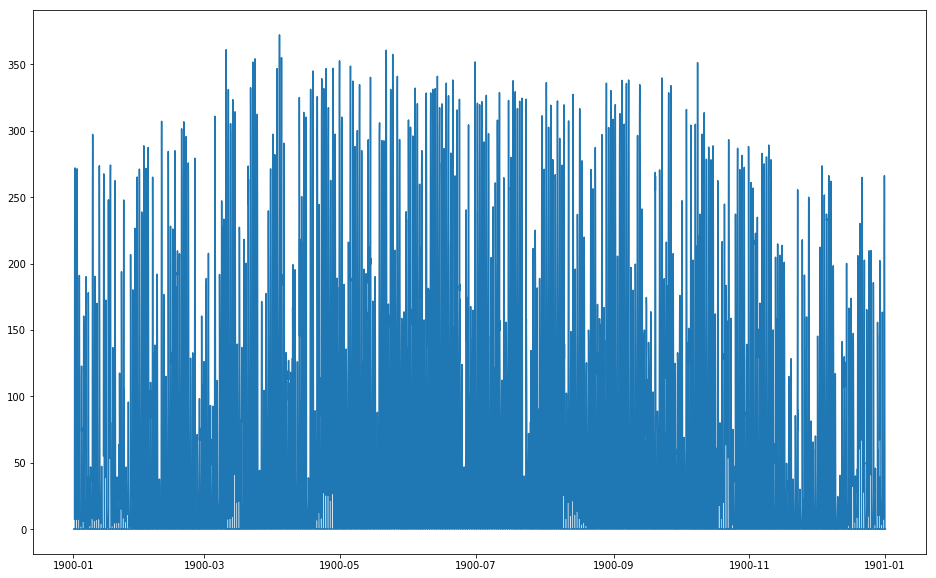

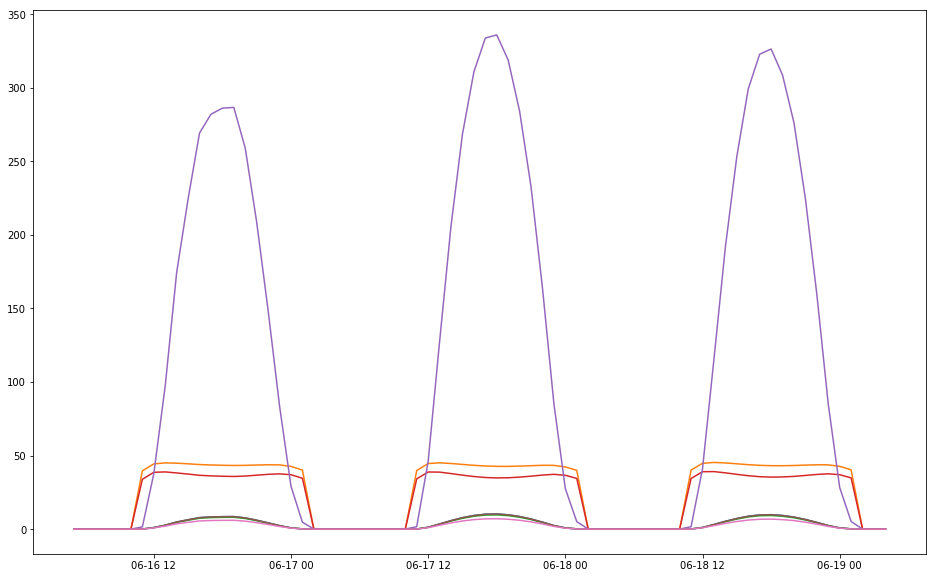

In [15]:
# calculate DC power of module 
IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_pvsyst(effective_irradiance = poa_irrad['poa_global'], temp_cell = pvtemps,
                                                         alpha_sc = module_parameters['alpha_sc'],
                                                         gamma_ref = module_parameters['gamma_ref'],
                                                         mu_gamma = module_parameters['mu_gamma'],
                                                         I_L_ref = module_parameters['I_L_ref'],
                                                         I_o_ref = module_parameters['I_o_ref'],
                                                         R_sh_ref = module_parameters['R_sh_ref'],
                                                         R_sh_0 = module_parameters['R_sh_0'],
                                                         R_s = module_parameters['R_s'],
                                                         cells_in_series = module_parameters['cells_in_series'])
        
dc = pvlib.pvsystem.singlediode(IL, I0, Rs, Rsh, nNsVth)


plt.figure(figsize=(16, 10))
plt.plot(dc.p_mp)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(dc['19000616':'19000618'])
plt.show()


In [16]:
yearly_dc = dc.p_mp.sum() / 1000.0  # kWh

print('annual dc = {} kWh/yr'.format(yearly_dc))
print('dc annual yield = {} kWh/kWp/yr'.format(yearly_dc/(module_parameters['Pmpp']/1000)))


annual dc = 559.9609849754474 kWh/yr
dc annual yield = 1534.1396848642396 kWh/kWp/yr
